# HW7 (20')

<font size='4'>
    
Please submit your assignment as an HTML or PDF file.

Print your name (First and Last) below.

Sofia Charlot

## General Remarks

<font size='4'>

- In this HW, you will start to **write your own functions** to achieve a specific task.
- The prompt to HW is **no longer specific** to each step. 
- I only describe the purpose of the task and provide an empty placeholder for each function. <br>
- It is your own responsibility to decompose the task and fill in the body of the function. <br>
- You will have one dataset to test.
- You only work on code sections starting with `Write youw own code`.
- Feel free to ask me questions or stop by OH. I am sure you will!

## Background on the study and dataset

<font size='4'>
    
- I studied statistical methodology on EEG with applications to Brain-Computer Interfaces as my dissertation topic.
- The particular modality is P300 Event-Related Response (ERP) based Brain-Computer Interface (BCI).
- This is used for ordinary communications when users cannot type words due to a physical disability, such as ALS or stroke.
- Users are asked to wear an EEG cap, sit in front of a virtual screen, and respond to the stimuli on the virtual screen.
    - <img src="figures/p300-eeg-bci-illustration.jpg" alt="drawing" width="800"/>
    - YouTube Link: https://www.youtube.com/watch?v=XIr2cRKFolY&t=1s (Data collection starts from 2:16).
- The biological mechanism is that when the human brain is exposed to a relevant but rare external stimuli, the brain elicits a so-called (target) P300 ERP that can be captured via the EEG recording, otherwise, when the human brain is exposued to a irrelevant (but regular) external stimuli, the brain does not elicit this P300 ERP. To simplify, we call it an non-target P300 ERP.
- The conventional framework is shown
    - <img src="figures/bci_conventional_framework.png" alt="drawing" width="800"/>
    - The statistical problem is simply a **binary classification** problem.
- The resulting dataset contains a truncated EEG signal matrix of which dimension is (3420, 400) and labeled vector of which dimension is (3420, 1) telling whether it is a target or non-target stimuli.
    - <img src="figures/eeg_signal_data_structure.png" alt="drawing" width="800"/>
    - Here, 3420 refers to the total number of stimuli, while 400 is the total feature length.
    - The truncated dataset has 16 electrode, and each electrode has a 25 time points corresponding to the first 800 ms after each stimulus.
    - <img src="figures/electrode_location.png" alt="drawing" width="400"/>
- In HW 7, you are going to **validate the signal component between target and non-target ERPs**, which is an important descriptive step right after signal processing and feature extraction. In later HWs, you will have the chance to explicitly perform signal processing and feature extraction, perform binary classification tasks using various ML methods, and convert them into character-level probability calculation.

In [2]:
# import relevant packages
import os
import numpy as np
import scipy.io as sio # This will be used to load an MATLAB file
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf as bpdf # This will be used to create a PDF to store multiple plots in the same file
# You may not use this function for HW7, but when we start to move everything to .py file, you will use it.

## Global constants and parent directory (1')

<font size='4'>

- You do not need to modify the global parameters.
- You need to change your parent directory to your own, preferably `.../GitHub/BIOS-584`.
- If you **fetch origins**, you will find a dataset called `K114_001_BCI_TRN_Truncated_Data_0.5_6.mat` under the `data` folder.

In [3]:
bp_low = 0.5
bp_upp = 6
electrode_num = 16
electrode_name_ls = ['F3', 'Fz', 'F4', 'T7', 'C3', 'Cz', 'C4', 'T8', 'CP3', 'CP4', 'P3', 'Pz', 'P4', 'PO7', 'PO8', 'Oz']

parent_dir = '/Users/sofia/Documents/GitHub/BIOS-584'
parent_data_dir = '/Users/sofia/Documents/GitHub/BIOS-584/data'.format(parent_dir)
time_index = np.linspace(0, 800, 25) # This is a hypothetic time range up to 800 ms after each stimulus.

subject_name = 'K114'
session_name = '001_BCI_TRN'

<font size='4'>

- Use `os.mkdir()` and `os.path.exists()` to create a new folder called `subject_name` under your `parent_dir`.
- Make sure to use `if` to check whether the proposed directory exists because Python will yield an error if so.
- For HW7, you do not have to export anything outside Jupyter notebook. That will be your HW8.
- But You should still create a new directory below. (1')

In [20]:
# Write your own code:
os.mkdir(subject_name)

if os.path.exists(subject_name):
    print("Directory made")
else:
    print("No directory")

Directory made


## Load the MATLAB .mat file (4')

<font size='4'>

- Use `sio.loadmat()` function to load the dataset and rename it as `eeg_trunc_obj`. (1')

In [4]:
# Write your own code:
eeg_trunc_obj = sio.loadmat('/Users/sofia/Documents/GitHub/BIOS-584/data/K114_001_BCI_TRN_Truncated_Data_0.5_6.mat')

<font size='4'>

- Although we haven't covered `dict` data type yet, you have the chance to use it in practice.
- Print out `eeg_trunc_obj.keys()` and find the name `Signal` and `Type`. Those are the only two things we will use for HW7. (1')
- We extract information from `dict` using the syntax `variable_name = dict_obj['key_name']`.
- Rename the variable associated with `Signal` to `eeg_trunc_signal` and `Type` as `eeg_trunc_type`. (1')
- Print out their shapes respectively. For `eeg_trunc_type`, use `np.squeeze()` to convert it to a 1d-array. Make sure to spell out the correct `axis` parameter.
- What does `eeg_trunc_type` contain? (1')

In [18]:
# Write your own code:
print(eeg_trunc_obj.keys())

eeg_trunc_signal = eeg_trunc_obj['Signal']
eeg_trunc_type = eeg_trunc_obj['Type']

print(eeg_trunc_signal.shape)
eeg_trunc_type = np.squeeze(eeg_trunc_type, axis=1)
print(eeg_trunc_type.shape)

#The eeg_trunc_type contains the different categories each EEG sample falls under. 

dict_keys(['__header__', '__version__', '__globals__', 'Code', 'IndexBegin', 'IndexTag', 'LetterTable', 'Signal', 'Text', 'Type'])
(3420, 400)
(3420,)


In [19]:
print(np.unique(eeg_trunc_type))  # should contain 0 and 1
print(eeg_trunc_signal.shape)     # check rows and columns

[-1  1]
(3420, 400)


## Write a function to compute type-specific sample mean and sample covariance (4')

<font size='4'>

- If you look at the individual signal segment, you cannot find anything interesting because the useful P300 ERP is overwhelmed in the noise.
- However, if you select all signals associated with target ERPs (i.e., `eeg_trunc_type == 1`) and take the average, you will find a clear pattern. Similarly do it for non-target ERPs.
- Please write a function called `produce_trunc_mean_cov` that takes the three parameters and output a list of five elements as follows:
- Make sure the dimensions of output arrays match with my description.

In [20]:
# Write your own code:
# Note to myself: keep r""" """ from the function.
def produce_trun_mean_cov(eeg_trunc_signal, eeg_trunc_type, E_val):
    total_features = eeg_trunc_signal.shape[1]
    length_per_electrode = total_features // E_val

    tar_data = eeg_trunc_signal[eeg_trunc_type == 1, :]
    ntar_data = eeg_trunc_signal[eeg_trunc_type == -1, :]

    signal_tar_mean = np.zeros((E_val, length_per_electrode))
    signal_ntar_mean = np.zeros((E_val, length_per_electrode))
    signal_tar_cov = np.zeros((E_val, length_per_electrode, length_per_electrode))
    signal_ntar_cov = np.zeros((E_val, length_per_electrode, length_per_electrode))
    signal_all_cov = np.zeros((E_val, length_per_electrode, length_per_electrode))

    for e in range(E_val):
        start_idx = e * length_per_electrode
        end_idx = start_idx + length_per_electrode

        tar_e = tar_data[:, start_idx:end_idx]
        ntar_e = ntar_data[:, start_idx:end_idx]
        all_e = eeg_trunc_signal[:, start_idx:end_idx]

        signal_tar_mean[e, :] = np.mean(tar_e, axis=0)
        signal_ntar_mean[e, :] = np.mean(ntar_e, axis=0)

        signal_tar_cov[e, :, :] = np.cov(tar_e, rowvar=False)
        signal_ntar_cov[e, :, :] = np.cov(ntar_e, rowvar=False)
        signal_all_cov[e, :, :] = np.cov(all_e, rowvar=False)

    return signal_tar_mean, signal_ntar_mean, signal_tar_cov, signal_ntar_cov, signal_all_cov

## Write a function to plot sample means (3') and sample covariances (3')

<font size='4'>

- After you extract the sample mean and sample covariance, you can visualize those to gain a better understanding.
- You will write two functions to visualize the sample mean (`plot_trunc_mean`) and sample covariance (`plot_trunc_cov`).

For sample mean:
- You are going to have 16 plots and put them into a 4x4 grid such that channels F3, C3, CP3, and P4 show up on the first, second, third, and fourth row, but all within the first column.
- In each subplot, you are going to plot target sample mean and non-target sample mean simulatenously and label them `Target` and `Non-Target` respectively.
- Use red for target sample mean and blue for non-target sample mean.
- Add `Time (ms)` to the label of x-axis, `Amplitude (muV)` to the label of y-axis for each subplot.
- Add the channel name to the title for each sub plot (Use `electrode_name_ls`)
- Add a subject name to the super title (shown on the top of the entire 4x4 grid).
- Display the final plot.

In [21]:
def plot_trunc_mean(
    eeg_tar_mean, eeg_ntar_mean, subject_name, time_index, E_val, electrode_name_ls,
    y_limit=np.array([-5, 8]), fig_size=(12, 12), save_path=None
):
    fig, axes = plt.subplots(4, 4, figsize=fig_size)
    fig.suptitle(f"Subject: {subject_name}", fontsize=16, fontweight="bold")
    
    for i in range(E_val):
        row, col = i // 4, i % 4
        ax = axes[row, col]
        
        ax.plot(time_index, eeg_tar_mean[i, :], color='red', label='Target')
        ax.plot(time_index, eeg_ntar_mean[i, :], color='blue', label='Non-Target')
        ax.set_title(electrode_name_ls[i])
        ax.set_xlabel("Time (ms)")  
        ax.set_ylabel("Amplitude (muV)")
        ax.set_ylim(y_limit)
    
        if i == 0:
            ax.legend(loc='upper right', fontsize=8)
            
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

<font size='4'>
For sample covariance:

- You also put 16 electrode-specific covariance plots and squeeze them into a 4x4 grid such that channels F3, C3, CP3, and P4 show up on the first, second, third, and fourth row, but all within the first column.
- You save **three** plots, **one for target signals, one for non-target, and one for all**.
- Use `np.meshgrid` and `plt.contourf()` to generate the plot. You are welcome to use other function. You can use whatever color palette but make sure to mark the color bar.
- For x-axis, the time index should increase from left to right, while for y-axis, the time index should increase from top to bottom.
- Add `Time (ms)` to the label of x- and y-axes.
- Add channel name to the title of each subplot.
- Add `Target`, `Non-target`, or `All` to the super title of each plot.
- Display the final three plots.

In [23]:
def plot_trunc_cov(
    eeg_cov, cov_type, time_index, subject_name, E_val, electrode_name_ls, fig_size=(12,12), save_dir=None
):
    fig, axes = plt.subplots(4, 4, figsize=fig_size)
    fig.suptitle(f"{subject_name}{cov_type}: Covariance", fontsize=16, fontweight="bold")

    X, Y = np.meshgrid(time_index, time_index)
    
    for i in range(E_val):
        row, col = i // 4, i % 4
        ax = axes[row, col]
        cov_matrix = eeg_cov[i, :, :]

        c = ax.contourf(X, Y, cov_matrix, cmap='viridis')
        fig.colorbar(c, ax=ax, fraction=0.046, pad=0.04)
    
        ax.set_title(electrode_name_ls[i])
        ax.set_xlabel("Time (ms)")  
        ax.set_ylabel("Time (ms)")
        ax.invert_yaxis()
        
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

## Call your function and apply it to a particular participant K114. (5')

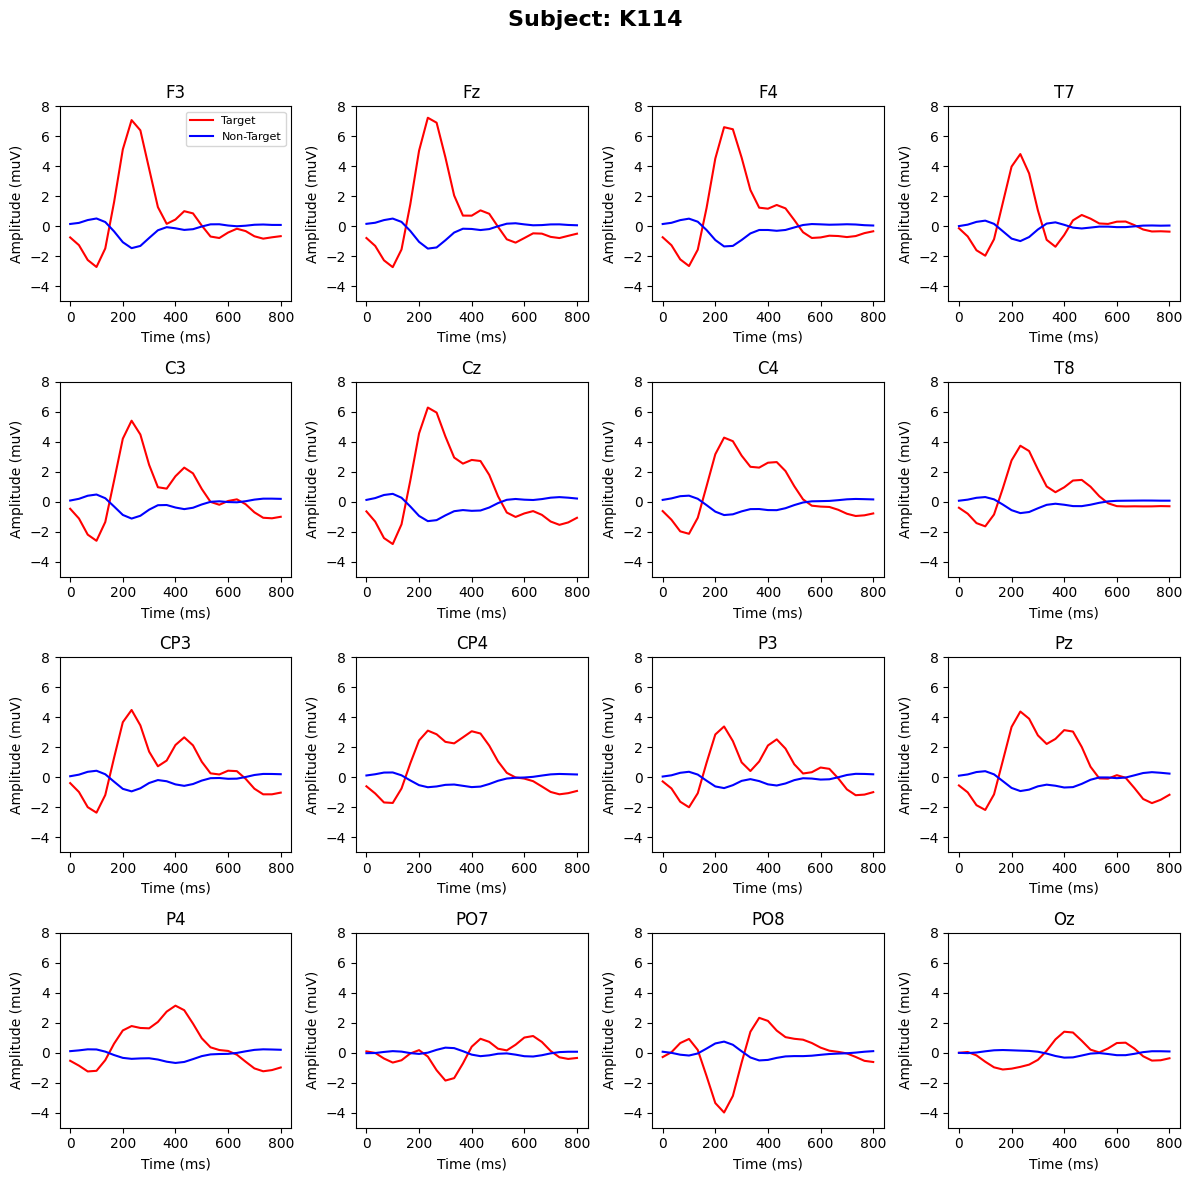

In [25]:
# Write your own code: (only call produce_trun_mean_cov in this code section)

E_val = 16

output = produce_trun_mean_cov(eeg_trunc_signal, eeg_trunc_type, E_val)

signal_tar_mean, signal_ntar_mean, signal_tar_cov, signal_ntar_cov, signal_all_cov = output

plot_trunc_mean(
    eeg_tar_mean=signal_tar_mean, 
    eeg_ntar_mean=signal_ntar_mean, 
    subject_name=subject_name, 
    time_index=time_index, 
    E_val=E_val, 
    electrode_name_ls=electrode_name_ls
)

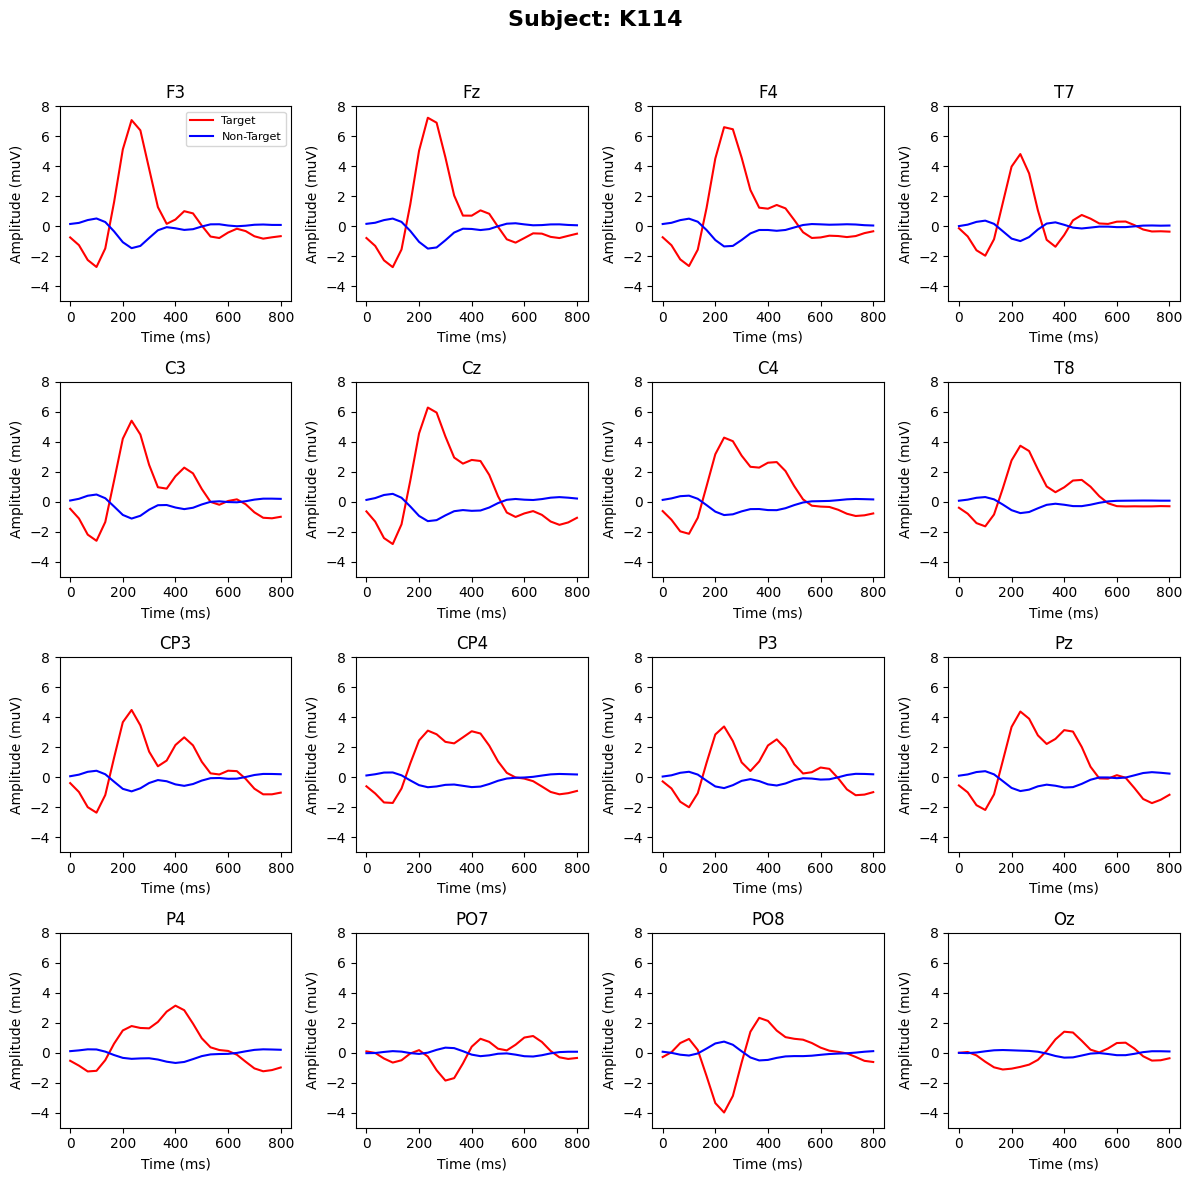

In [26]:
# Write your own code: (only call plot_trunc_mean in this code section)
time_index = np.linspace(0, 800, 25)

E_val = 16

eeg_tar_mean, eeg_ntar_mean, eeg_tar_cov, eeg_ntar_cov, eeg_all_cov = output

plot_trunc_mean(
    eeg_tar_mean=signal_tar_mean, 
    eeg_ntar_mean=signal_ntar_mean, 
    subject_name=subject_name, 
    time_index=time_index, 
    E_val=E_val, 
    electrode_name_ls=electrode_name_ls
)    

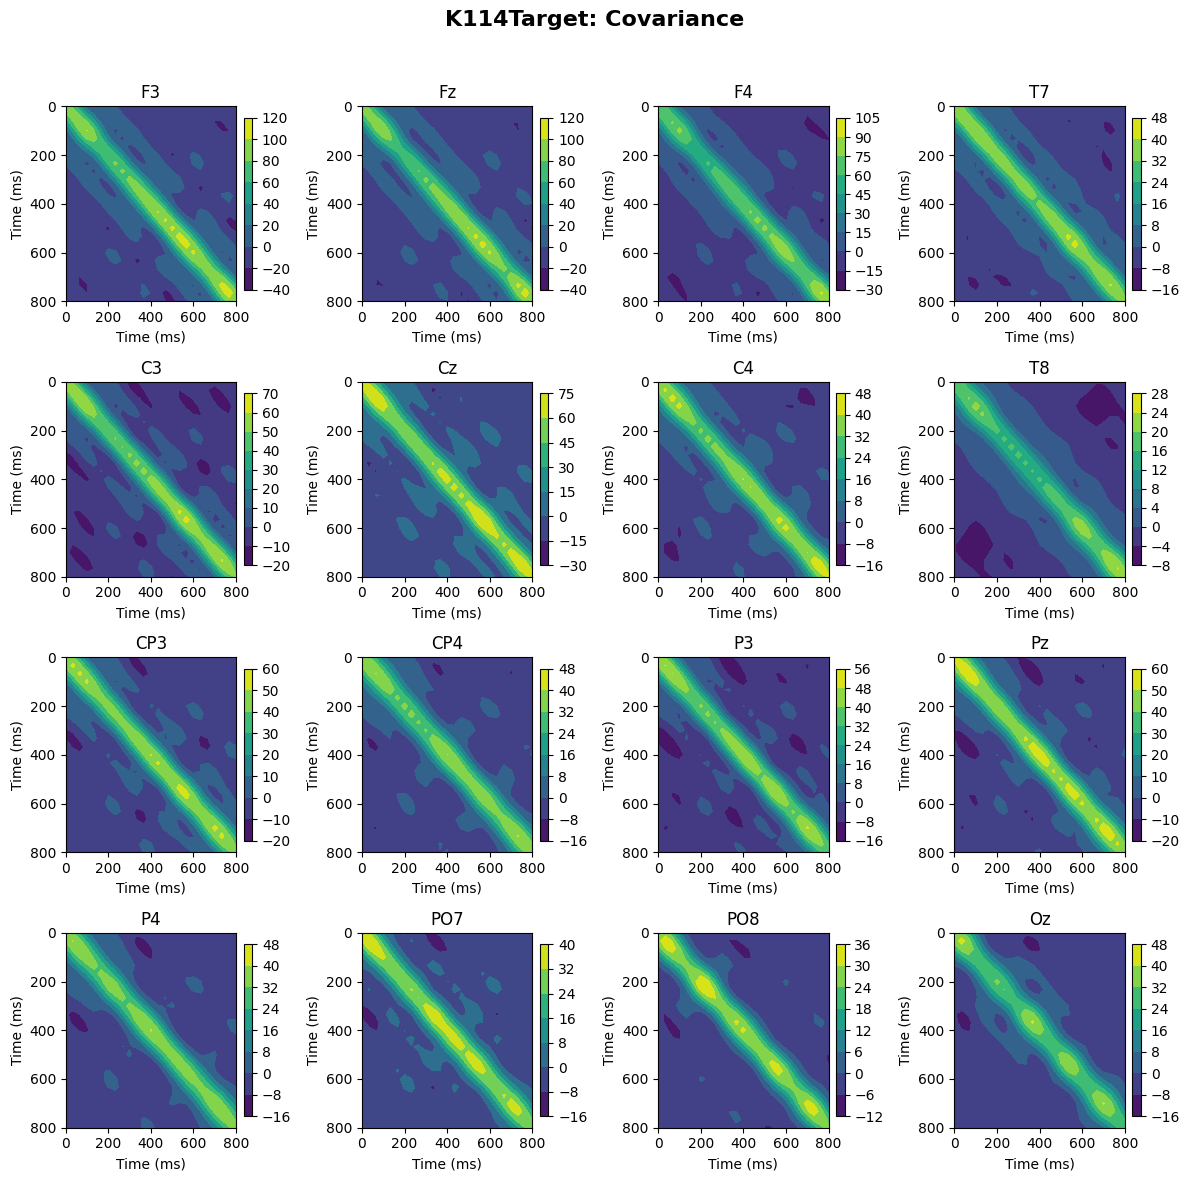

In [27]:
# Write your own code: call plot_trunc_cov for target covariance only
time_index = np.linspace(0, 800, 25)

E_val = 16

plot_trunc_cov(
    eeg_cov=eeg_tar_cov, 
    cov_type= "Target",
    time_index=time_index,
    subject_name="K114",
    E_val=E_val,
    electrode_name_ls= electrode_name_ls
)


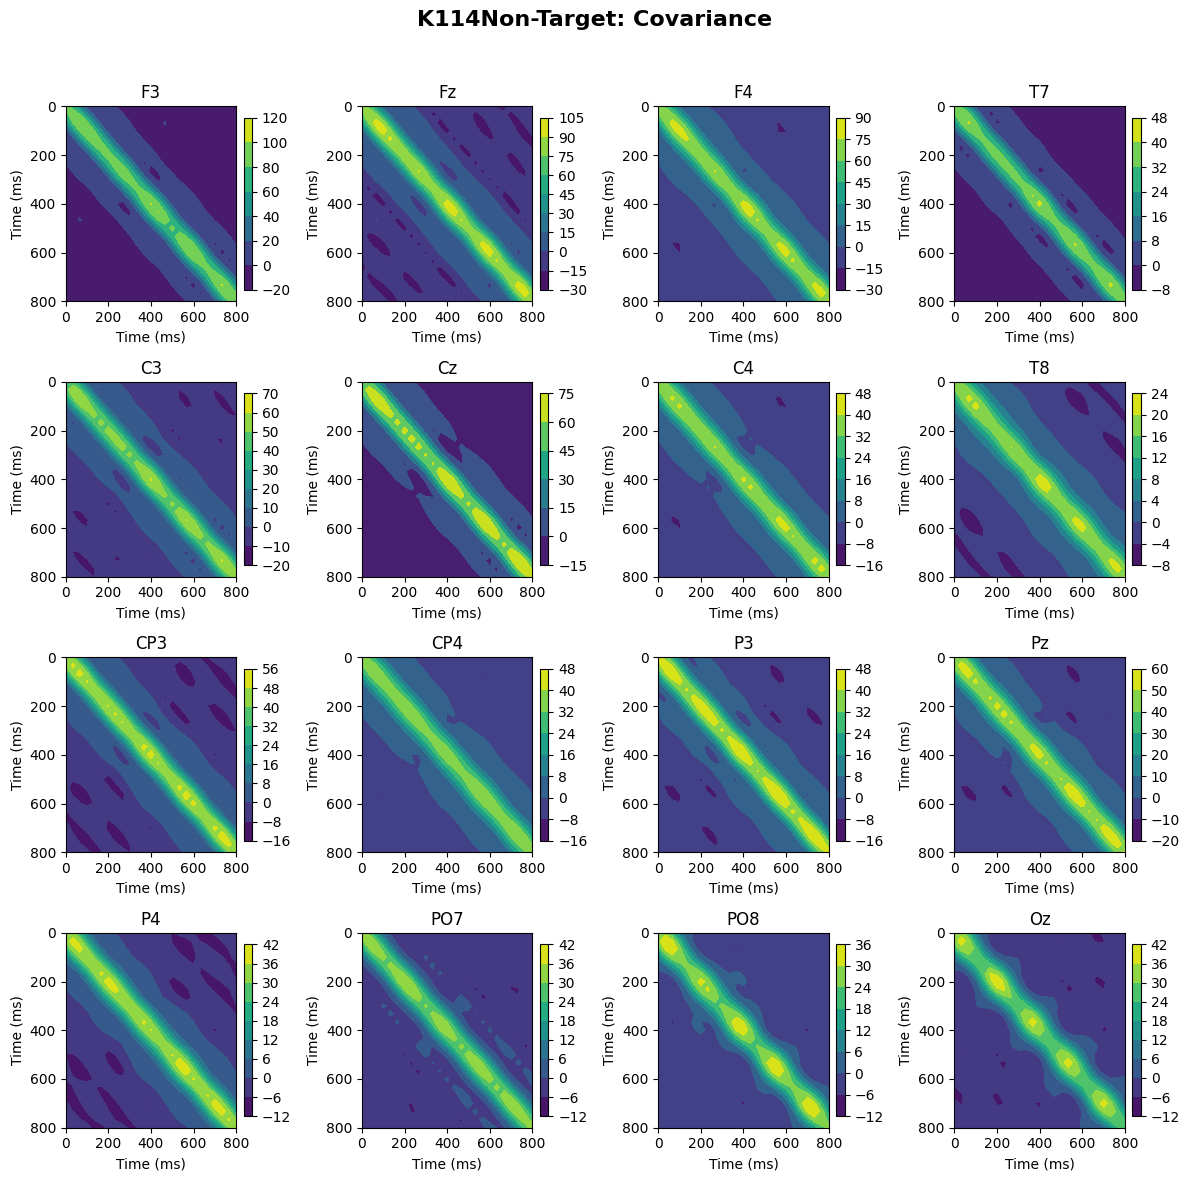

In [28]:
# Write your own code: call plot_trunc_cov for non-target covariance only
time_index = np.linspace(0, 800, 25)

E_val = 16

plot_trunc_cov(
    eeg_cov=eeg_ntar_cov, 
    cov_type= "Non-Target",
    time_index=time_index,
    subject_name="K114",
    E_val=E_val,
    electrode_name_ls= electrode_name_ls
)

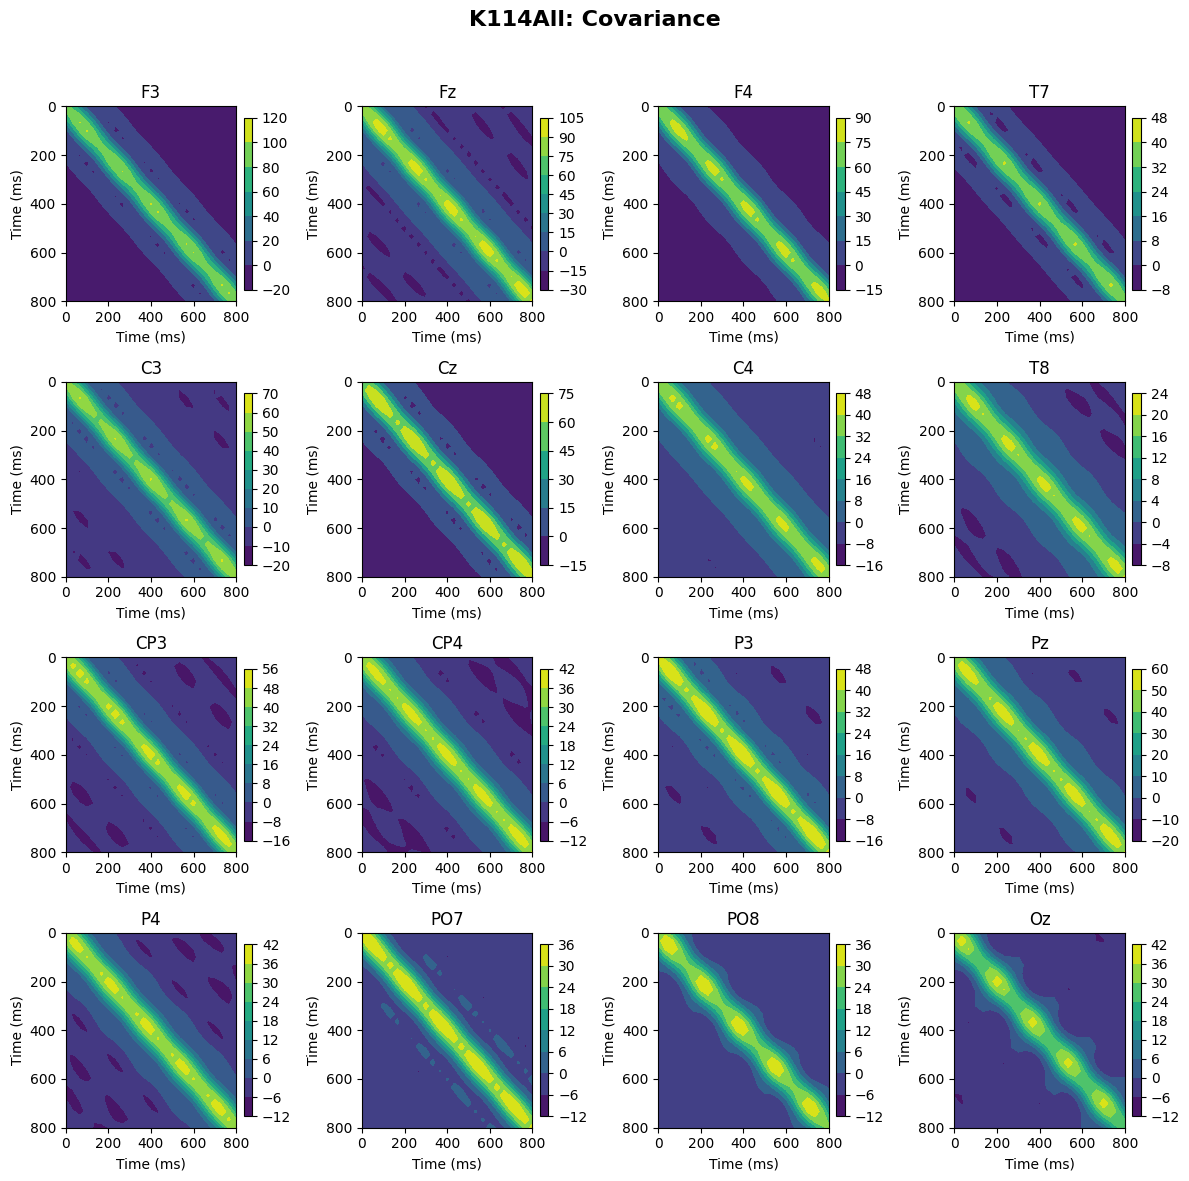

In [29]:
# Write your own code: call plot_trunc_cov for all covariance only
time_index = np.linspace(0, 800, 25)

E_val = 16

plot_trunc_cov(
    eeg_cov=eeg_all_cov, 
    cov_type= "All",
    time_index=time_index,
    subject_name="K114",
    E_val=E_val,
    electrode_name_ls= electrode_name_ls
)